In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json
import numpy as np

In [2]:
EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
# EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)

In [3]:
SMOOTHING = False

In [4]:
mean_cv_df = pd.read_pickle('{}/method-mean-cv-{}-df.pkl'.format(EXTRACTED_FEATURES_DIR, 'raw' if not SMOOTHING else 'smoothed'))

In [5]:
mean_cv_df.mean_cv.min()

0.30864363041523224

In [6]:
mean_cv_df.columns

Index(['calc_method', 'mean_cv'], dtype='object')

In [7]:
len(mean_cv_df)

100

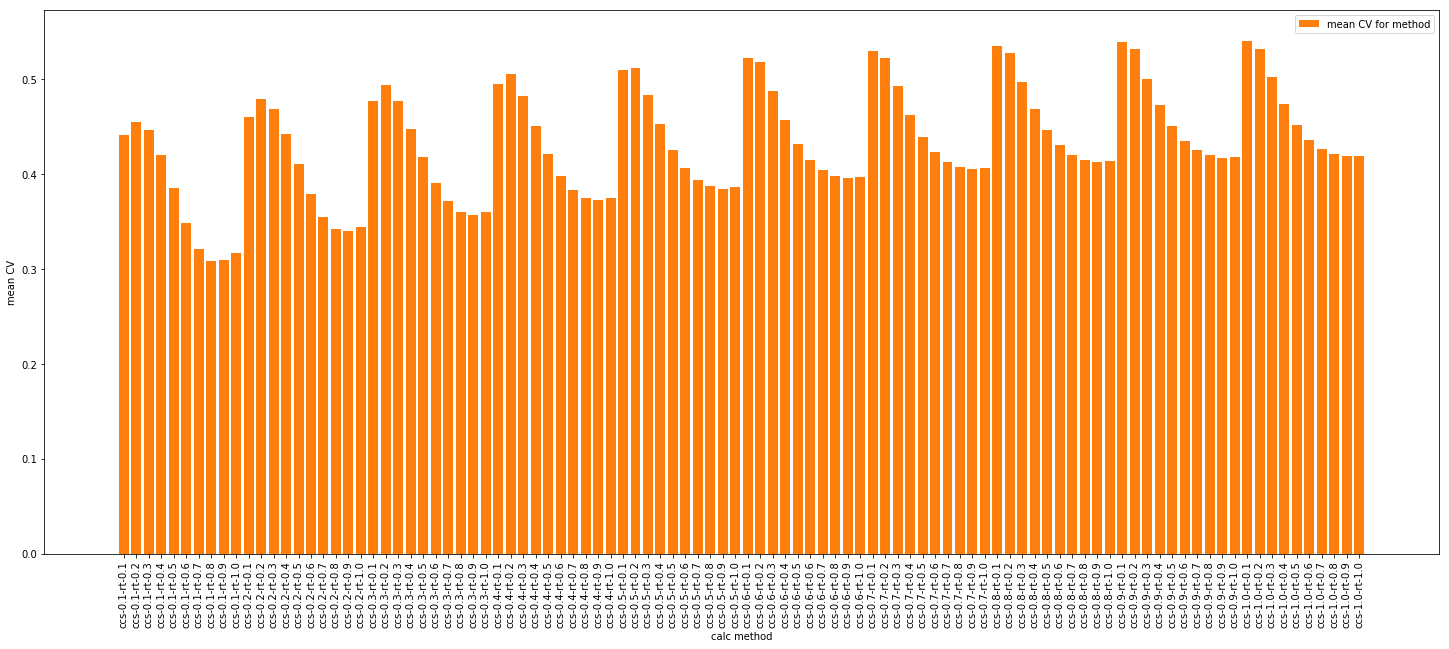

In [8]:
f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(25)

plt.margins(0.06)

# plt.title('intensities from 1to1 runs for sequence {}, charge {}\nmean 1to1 {}'.format(selected_sequence, selected_sequence_charge, mean_1to1))

ax1.bar(x=mean_cv_df.calc_method, height=mean_cv_df.mean_cv, color='tab:orange', linewidth=0, alpha=1.0, label='mean CV for method')

plt.xlabel('calc method')
plt.ylabel('mean CV')
plt.legend(loc='best')

plt.xticks(rotation=90)

plt.show()

In [9]:
mean_cv_df['ccs_proportion'] = mean_cv_df.apply(lambda row: row.calc_method.split('-')[1], axis=1)
mean_cv_df['rt_proportion'] = mean_cv_df.apply(lambda row: row.calc_method.split('-')[3], axis=1)
mean_cv_df.sort_values(by=['rt_proportion','ccs_proportion'], ascending=True, inplace=True)

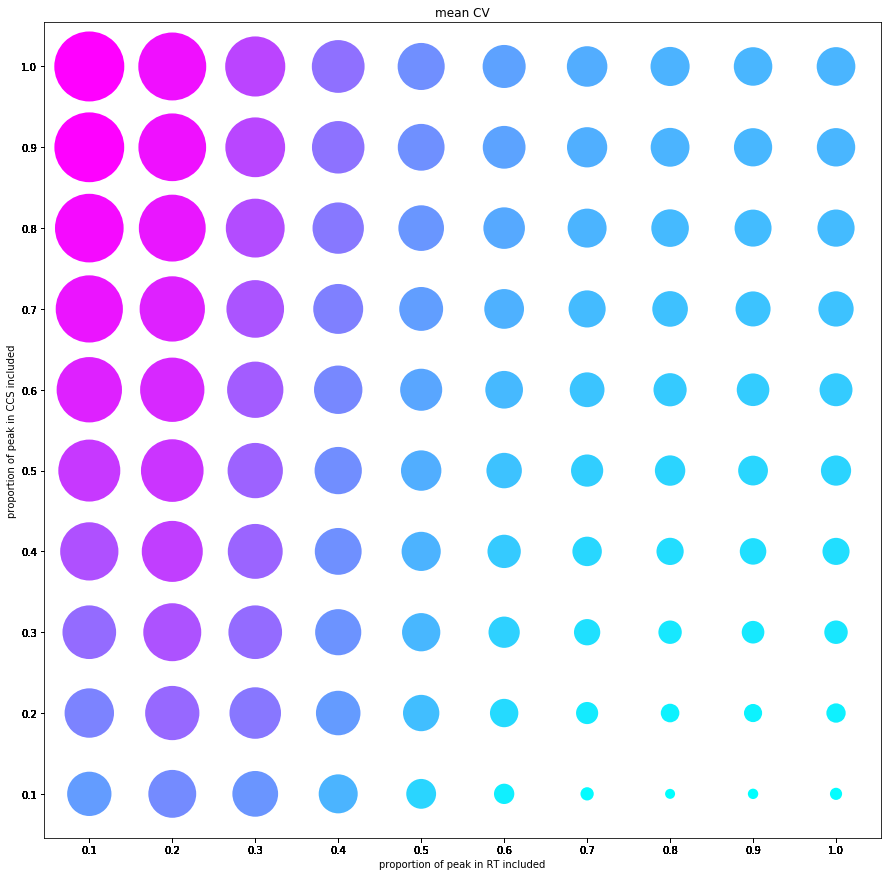

In [10]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

max_marker_size = 70
min_marker_size = 10
mean_cv_df['marker_size'] = (((mean_cv_df.mean_cv - mean_cv_df.mean_cv.min()) / (mean_cv_df.mean_cv.max() - mean_cv_df.mean_cv.min()) * (max_marker_size - min_marker_size)) + min_marker_size) ** 2

ax1.scatter(mean_cv_df.rt_proportion, mean_cv_df.ccs_proportion, marker='o', c=mean_cv_df.marker_size, cmap="cool", lw=0, s=mean_cv_df.marker_size, alpha=1.0)

plt.xlabel('proportion of peak in RT included')
plt.ylabel('proportion of peak in CCS included')
plt.title('mean CV')
plt.xticks(mean_cv_df.rt_proportion)
plt.yticks(mean_cv_df.ccs_proportion)

plt.show()

In [11]:
mean_cv_df.loc[mean_cv_df.mean_cv.idxmin()]

calc_method       ccs-0.1-rt-0.8
mean_cv                 0.308644
ccs_proportion               0.1
rt_proportion                0.8
marker_size                  100
Name: 7, dtype: object

In [12]:
mean_cv_df.sort_values(by=['mean_cv'], ascending=[True], inplace=True)

In [13]:
mean_cv_df[:5]

,calc_method,mean_cv,ccs_proportion,rt_proportion,marker_size
7,ccs-0.1-rt-0.8,0.308644,0.1,0.8,100.000000
8,ccs-0.1-rt-0.9,0.310237,0.1,0.9,108.419259
9,ccs-0.1-rt-1.0,0.317005,0.1,1.0,147.981622
6,ccs-0.1-rt-0.7,0.321327,0.1,0.7,176.456126
18,ccs-0.2-rt-0.9,0.340120,0.2,0.9,329.381906


In [14]:
mean_cv_df.to_csv('{}/mean_cv.csv'.format(EXTRACTED_FEATURES_DIR), index=False)

#### intensity CV across all files for each sequence

In [15]:
method_cv_df = pd.read_pickle('{}/sequence-cv-by-method-{}-df.pkl'.format(EXTRACTED_FEATURES_DIR, 'raw' if not SMOOTHING else 'smoothed'))

In [16]:
method_cv_df.columns

Index(['calc_method', 'sequence', 'charge', 'intensity_cv'], dtype='object')

In [17]:
len(method_cv_df)

1389000

In [25]:
selected_method_df = method_cv_df[method_cv_df.calc_method == 'ccs-0.1-rt-0.8']

In [26]:
len(selected_method_df)

13890

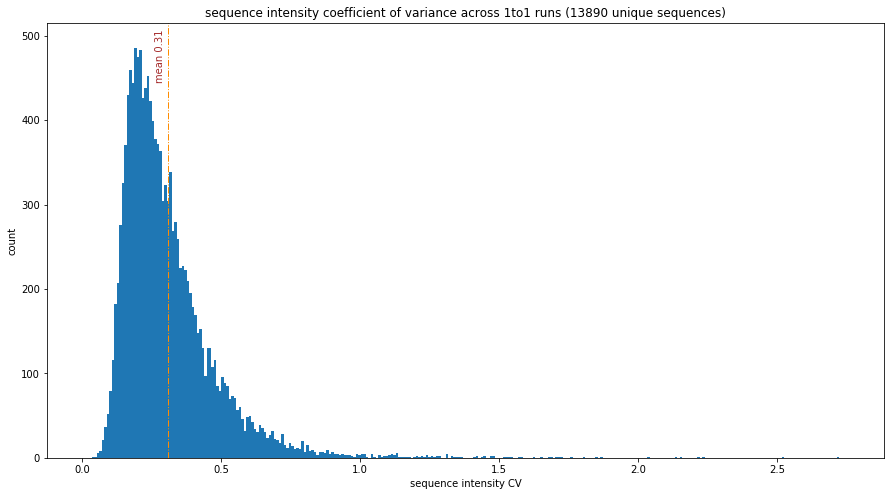

In [27]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = selected_method_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('sequence intensity coefficient of variance across 1to1 runs ({} unique sequences)'.format(len(selected_method_df)))

plt.show()

#### check there was an intensity calculation for each sequence in all 10 runs

In [28]:
intensities_df = pd.read_pickle('{}/intensities-{}-df.pkl'.format(EXTRACTED_FEATURES_DIR, 'raw' if not SMOOTHING else 'smoothed'))

In [29]:
intensities_df.columns

Index(['sequence', 'charge', 'file_idx', 'calc_method', 'preprocessing',
       'ccs_proportion', 'rt_proportion', 'parametric_intensity'],
      dtype='object')

In [30]:
len(intensities_df)

13890000

#### show the CV of the top-3 intensity method

In [32]:
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)

In [33]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,intensity from features where batch==\'1to1\' and number_of_runs_extracted==10', db_conn)
db_conn.close()

In [34]:
len(sequences_df)

138900

In [37]:
intensity_cv_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge']):
    intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
    intensity_cv_l.append((group_name[0], group_name[1], intensity_cv))
intensity_cv_df = pd.DataFrame(intensity_cv_l, columns=['sequence','charge','intensity_cv'])

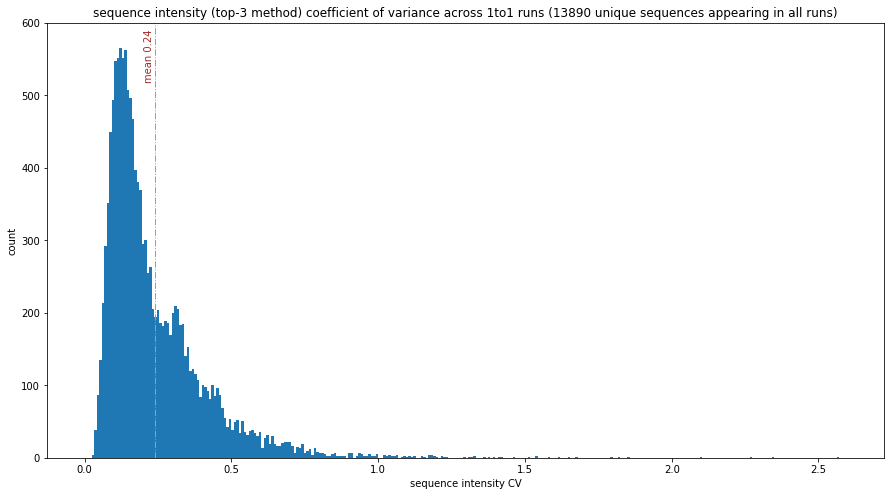

In [38]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = intensity_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('sequence intensity (top-3 method) coefficient of variance across 1to1 runs ({} unique sequences appearing in all runs)'.format(len(intensity_cv_df)))

plt.show()

#### dynamic range of top-3 method versus ccs-0.1-rt-0.8 method

In [40]:
parametric_search_intensities_df = intensities_df[intensities_df.calc_method == 'ccs-0.1-rt-0.8']
len(parametric_search_intensities_df)

138900

In [44]:
merged_df = pd.merge(sequences_df, parametric_search_intensities_df[['sequence','charge','file_idx','parametric_intensity']], how='inner', left_on=['sequence','charge','file_idx'], right_on=['sequence','charge','file_idx'])


In [45]:
merged_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity', 'parametric_intensity'], dtype='object')

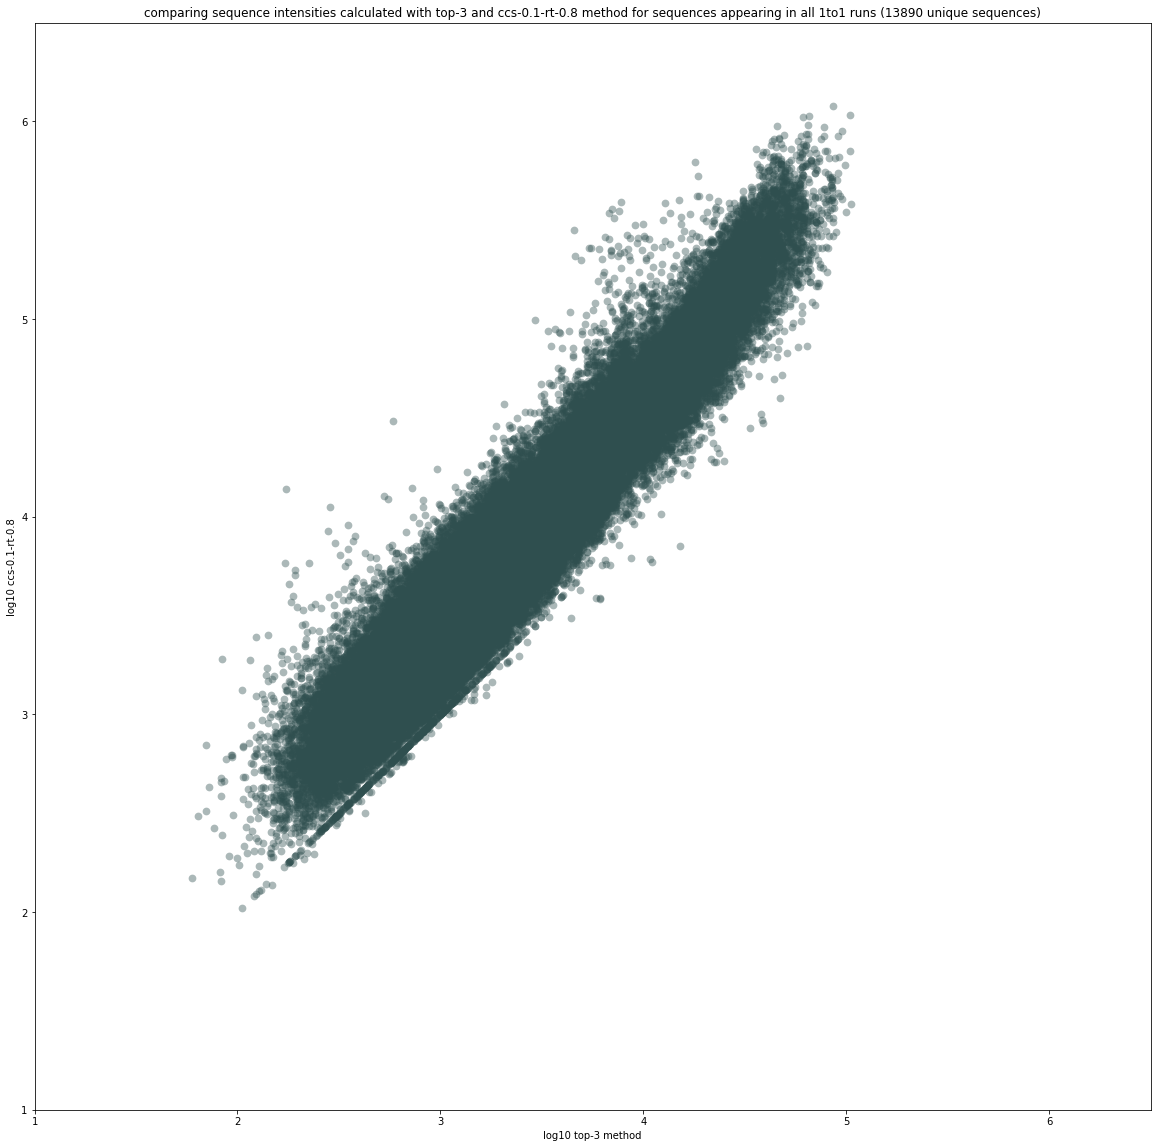

In [66]:
f, ax = plt.subplots()
f.set_figheight(20)
f.set_figwidth(20)

ax.set_title('comparing sequence intensities calculated with top-3 and ccs-0.1-rt-0.8 method for sequences appearing in all 1to1 runs ({} unique sequences)'.format(len(selected_method_df)))

ax.scatter(np.log10(merged_df.intensity), np.log10(merged_df.parametric_intensity), marker='o', color='darkslategray', lw=0, s=60, alpha=0.4)

# set up axes
ax.set_xlabel('log10 top-3 method')
ax.set_ylabel('log10 ccs-0.1-rt-0.8')

plt.xlim((1,6.5))
plt.ylim((1,6.5))

plt.show()    

In [60]:
merged_df.to_csv('~/intensity_comparison.csv', index=False)